In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rc('figure',titlesize=8);plt.rc('axes',labelsize=8);plt.rc('xtick',labelsize=8);plt.rc('ytick',labelsize=8);plt.rc('legend', fontsize=8);plt.rc('font', size=8);plt.rc('figure', titlesize=10)
import numpy as np
import pandas as pd

In [2]:
plt.rcParams['figure.dpi'] = 150
np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
import warnings
def display_table(x):
    with warnings.catch_warnings() and pd.option_context('display.latex.repr', True):
        warnings.simplefilter(action='ignore', category=FutureWarning)
        display(x)

In [4]:
%pip install yfinance requests-cache

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 97.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 79.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 110.3 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 500.6/500.6 kB 76.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.7/247.7 kB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.2/160.2 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 10.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the package

In [5]:
import yfinance as yf
import pandas_datareader as pdr
import requests_cache
session = requests_cache.CachedSession()

In [6]:
import scipy.optimize as sco
import statsmodels.formula.api as smf

# Importing Data

In [7]:
Stocks = yf.download(tickers=['GME', 'UPST', 'MRNA'], session=session)
Returns = Stocks.loc['2021', 'Adj Close'].pct_change().dropna()
Returns.columns.name = 'Ticker'

[*********************100%***********************]  3 of 3 completed


# Question 1: Allocating $10,000 among 3 stocks without Margin Loan

***Calculations:***

In [8]:
def port_r(w, r):
    return  r.add(1).prod().dot(w)*-10000

In [9]:
weights = [.33, .33,.33]
res = sco.minimize( 
    fun=port_r, x0=weights, args=(Returns,),
    bounds=tuple((0,1) for x in weights),
    constraints=({'type': 'eq', 'fun': lambda x: x.sum() - 1}))
assert res['success'] 
res

     fun: -86023.18805197028
     jac: array([-86023.19, -22731.58, -34394.18])
 message: 'Optimization terminated successfully'
    nfev: 8
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([1., 0., 0.])

The above function minimizes the inverted returns of the portfolio returns function above. The output is an array of the optimal weights for maximizing returns based on the constraint that the weights are long only, utilize zero leverage, and sum to 1. Based on this output, the maximum portfolio allocation is investing ***all $10,000*** into GME.

In [13]:
print('Total Ending Value of the optimal portfolio without margin loan is ', -port_r(res['x'], Returns))
print('Total Return of the optimal portfolio without margin loan is ', (-port_r(res['x'], Returns) - 10000) / 10000 * 100, '%')

Total Ending Value of the optimal portfolio without margin loan is  86023.18805197028
Total Return of the optimal portfolio without margin loan is  760.2318805197028 %


If we receive the newspaper on the first day of the financial year, in order to maximize wealth, we would invest it all in GameStop if ***no margin loan*** has been provided using minimization function. The final wealth would be ***$86,023.19***, a return of 760.23%. This return is driven entirely by the return of GME over the period.

The equity value of the portfolio is shown graphically below:

In [14]:
def port_r_plot(w, r):
    return  r.add(1).cumprod().dot(w)*-10000

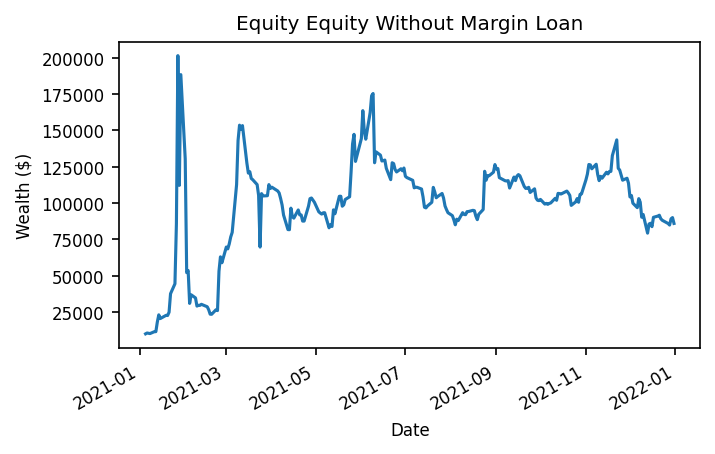

In [15]:
port_r_plot(res['x'], Returns).mul(-1).plot(figsize=(5,3))
plt.title('Equity Equity Without Margin Loan')
plt.ylabel('Wealth ($)'); plt.show()

# Question 2: Allocating $10,000 among 3 stocks ***with*** margin loan

***Calculations:***

In [16]:
Returns_2 = Returns.copy()
Returns_2['Loan'] = 0

In [17]:
def port_loan(w, r):
    return  r.add(1).prod().dot(w)*-1

In [18]:
weights = [1.25,1.25,1.25,-2.75]
res_1 = sco.minimize( 
    fun = port_loan, x0 = weights, args = (Returns_2,),
    bounds = ((0,11),(0,11),(0,11),(-10,0)),
    constraints=({'type': 'eq', 'fun': lambda x: x.sum() - 1},
        {'type': 'ineq', 'fun': lambda x: Returns_2.add(1).cumprod().dot(x).min()}))
assert res_1['success'] 
res_1

     fun: -84.6255068571659
     jac: array([-8.6 , -2.27, -3.44, -1.  ])
 message: 'Optimization terminated successfully'
    nfev: 15
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([ 11.,   0.,   0., -10.])

In [19]:
print('Total Ending Equity of the optimal portfolio with margin loan is ', port_loan(res_1['x'], Returns_2)*-10000)
print('Total Return of the optimal portfolio with margin loan is ', ((((port_loan(res_1['x'], Returns_2)*-10000)-10000)/10000)*100), '%')

Total Ending Equity of the optimal portfolio with margin loan is  846255.068571659
Total Return of the optimal portfolio with margin loan is  8362.550685716591 %


In total, the levered portfolio had an ending value of 846,225 on a principal investment of 110,000. Because the initial equity of the position was only ever 10,000 the total levered return is thus ($846,225$-$110,000$)/$10,000$. Or 7,362%. This is a great example of the way leverage can amplify returns on the upside, as the returns are around 10x that of the unlevered portfolio.

The Equity Value of the levered portfolio versus the unlevered portfolio is shown graphically below. Because the initial value invested is 11x larger on the levered portfolio, the ending equity value is around 10x as large after loan repayment:

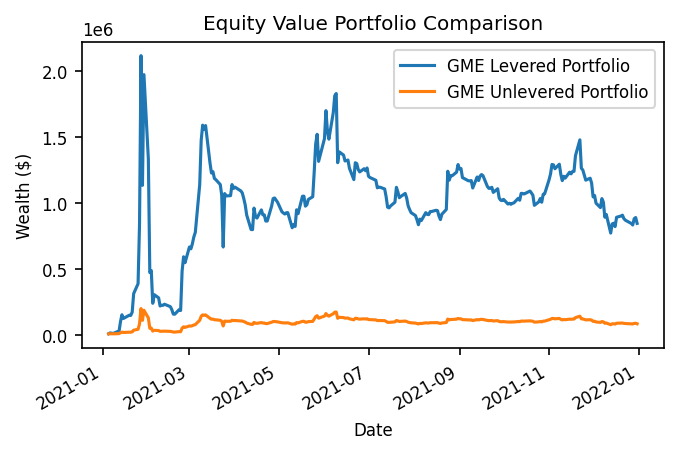

In [20]:
port_r_plot(res_1['x'], Returns_2).mul(-1).plot(figsize=(5,3))
port_r_plot(res['x'], Returns).mul(-1).plot(figsize=(5,3))
plt.title('Equity Value Portfolio Comparison')
plt.legend(labels = ('GME Levered Portfolio','GME Unlevered Portfolio'))
plt.xlabel('Date'); plt.ylabel('Wealth ($)'); plt.show()

# Question 3: Fama-French 3-Factor Model

In [21]:
ff = pdr.get_data_famafrench('F-F_Research_Data_Factors_daily', start='2021', session=session)

In [22]:
Returns_3 = Returns.copy()
Returns_3 = ff[0].merge(Returns_3, how = 'inner', on ='Date') # ff[0]:keep the number with percentage
Returns_3[['GME_ri','MRNA_ri','UPST_ri']]=Returns_3[['GME','MRNA','UPST']]*100 # multiple 100 keeping returns in percentage
Returns_3.rename(columns={'Mkt-RF': 'Rm', 'RF': 'rf'}, inplace=True)
Returns_3.eval('GME_Ri = GME_ri - rf', inplace=True)
Returns_3.eval('MRNA_Ri = MRNA_ri - rf', inplace=True)
Returns_3.eval('UPST_Ri = UPST_ri - rf', inplace=True)

***Fama-French 3 Factor Model for GameStop Unlevered Portfolio:***

Estimate the three-factor model for the unlevered GameStop portfolio with the daily returns data of the year of 2021

In [23]:
ff3_GME = smf.ols(formula='GME_Ri ~ Rm + SMB + HML', data=Returns_3.loc['2021':]).fit()
ff3_GME.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 GME_Ri   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     16.37
Date:                Mon, 05 Sep 2022   Prob (F-statistic):           9.86e-10
Time:                        23:22:20   Log-Likelihood:                -1044.0
No. Observations:                 251   AIC:                             2096.
Df Residuals:                     247   BIC:                             2110.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.4010      0.998      2.406      0.017       0.435       4.367
Rm            -4.4728      1.244     -3.596      0.000      -6.923      -2.023
SMB            8.1329      1.278      6.362      0.000       5.615      10.651
HML            1.5171      0.891      1.703      0.090      -0.237       3.272
==============================================================================
Omnibus:                      213.285   Durbin-Watson:                   1.709
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4339.535
Skew:                           3.265   Prob(JB):                         0.00
Kurtosis:                      22.295   Cond. No.                         1.80
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In the Fama-French 3 Factor Model for the unlevered Gamestop portfolio, we have an alpha of 2.4010%, indicating GME returned 2.4% per day unrelated to the other factors in the model. Annualizing this simply, this indicates an annual alpha of 604.8% over the period (daily alpha * trading days). The market risk premium (Rm) is -4.4728, indicating the company has a low, negative beta. The coefficient of SMB is large and positive, indicating that the company stock has a significant exposure to the small-stock risk factor, which makes sense because GME has a small market capitalization. The positive HML indicates a positive relationship with the value premium and a positive exposure to the value-stock risk factor, indicating GME is traded as a value stock. The graphical representation of these outputs is shown below:

***Graph for Unlevered GME Coefficient Estimate***

In [24]:
def coestimate(s, title):
    plt.bar(x=s.params.index, height=s.params, yerr=2*s.bse, alpha = 0.8)
    plt.xlabel('Factor'); plt.ylabel('Coefficient Estimate (%)')
    plt.title(title); plt.show()

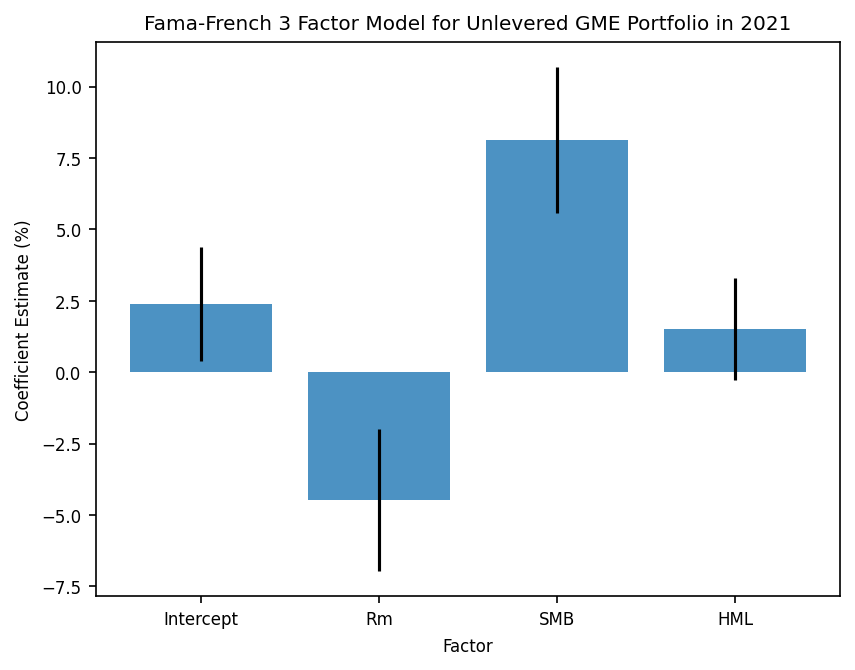

In [25]:
coestimate(ff3_GME, title = 'Fama-French 3 Factor Model for Unlevered GME Portfolio in 2021')

***Fama-French 3 Factor Model for GameStop Levered Portfolio***

In [26]:
Levered_GME = Returns_2.add(1).cumprod().mul(res_1['x']).mul(10000) 
Levered_GME = pd.DataFrame(Levered_GME.sum(axis=1))
Levered_GME.columns = ['Equity'] 

In [27]:
Levered_GME_Returns = Levered_GME.pct_change().mul(100).dropna()
Levered_GME_Returns.columns = ['Returns'] 
Levered = ff[0].merge(Levered_GME_Returns, how = 'inner', on ='Date')
Levered.columns = ['Rm', 'SMB', 'HML', 'RF', 'Equity']
Levered.eval('Port_Ri = Equity - RF', inplace=True)
Levered_reg = smf.ols(formula='Port_Ri ~ Rm + SMB + HML', data=Levered['2021':]).fit()
Levered_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Port_Ri   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     8.649
Date:                Mon, 22 Aug 2022   Prob (F-statistic):           1.77e-05
Time:                        14:50:33   Log-Likelihood:                -1172.7
No. Observations:                 250   AIC:                             2353.
Df Residuals:                     246   BIC:                             2368.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.4637      1.702      2.623      0.009       1.112       7.815
Rm            -4.9060      2.118     -2.317      0.021      -9.077      -0.735
SMB            9.6649      2.181      4.430      0.000       5.368      13.962
HML            2.7072      1.517      1.785      0.075      -0.280       5.694
==============================================================================
Omnibus:                      334.539   Durbin-Watson:                   1.810
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            29328.551
Skew:                           6.029   Prob(JB):                         0.00
Kurtosis:                      54.673   Cond. No.                         1.80
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

***Debt to Equity Ratio:***

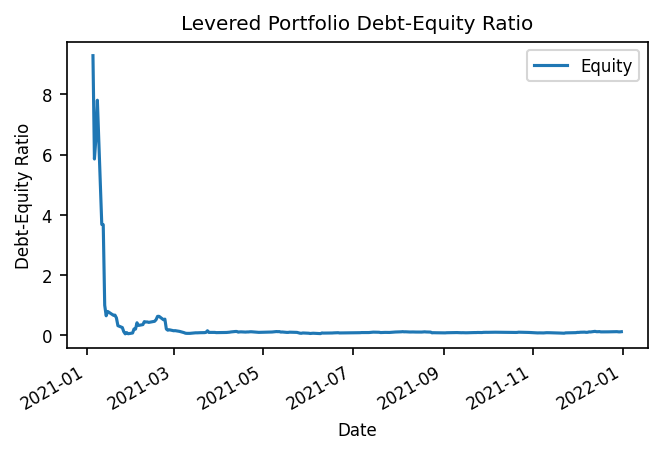

In [28]:
d_e_ratio = 100000/(Levered_GME[['Equity']])
d_e_ratio.plot(figsize=(5,3))
plt.title('Levered Portfolio Debt-Equity Ratio')
plt.ylabel('Debt-Equity Ratio'); plt.show()

We have an alpha of 4.4637% for the (levered Gamestop) portfolio in the Fama-French 3 Factor Model, meaning that the portfolio returned 4.4637% per day and around 1124.8524% annually. Because the average stock has a beta of 1, the portfolio has a low, negative beta of -4.9060, meaning that when the market moves up 1%, the portfolio decreases by 4% and vice versa (on average). The coefficient of SMB is 9.7740, suggesting that the portfolio has a positive exposure to the small-stock risk factor because the portfolio has more small capitalization companies (GME). The coefficient of HML is 2.7072, indicating that the portfolio has a positive relationship to the value-stock risk factor and a negative relationship to the growth-stock risk factor. 

Putting these values in context with the unlevered portfolio, the levered portfolio created just short of 2x the alpha, and marginally greater directional exposure for each of the factors. This makes sense because the large leverage used initially amplified returns and volatility in the beginning of the period, delivering significantly higher returns with the same directional movement against the benchmark. As these returns grew drastically, however, the multiplier on them diminished as the equity value increased. As the value of the assets increase, the portfolio naturally delevers. To show this, the ***Debt to Equity Ratio*** shown above reveals this drastic decrease due to the  fixed 100000 liability in the numerator, and the increasing equity in the denominator. As the percentage of loan getting smaller in the overall portfolio, it leads to a smaller multiplying factor on the returns, thus diminishing the marginal multiplier on the alpha and the coefficients. The graphical representation of these outputs is shown below:

***Graph for levered GME Portfolio Coefficient Estimate***

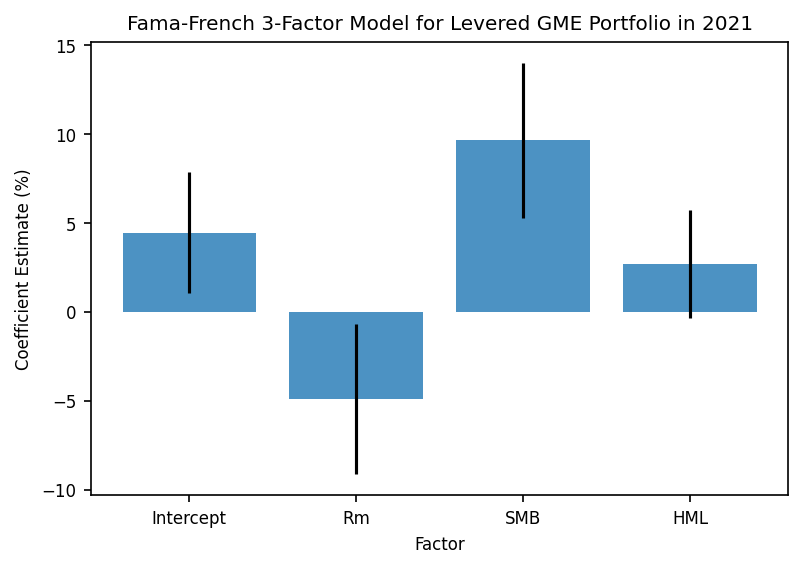

In [29]:
coestimate(Levered_reg, title = 'Fama-French 3-Factor Model for Levered GME Portfolio in 2021')

# Question 4: Invest since the close of the first trading day of March 2021

***Calculations:*** Investing since the close of the first trading day of March ***without margin loan***

We minimize the data frame to 10 months starting March 2nd, 2021, in order to see the impact on our investment strategy if we recieve the newspaper after the close of the first trading day of March 2021. 

In [30]:
Returns_4 = Returns['2021-03-02':'2021-12-31'].dropna()

In [31]:
weights_4 = [.33, .33,.33]
res_4 = sco.minimize(
    fun=port_r,
    x0=weights_4,
    args=(Returns_4,),
    bounds=tuple((0,1) for x in weights_4),
    constraints=({'type': 'eq', 'fun': lambda x: x.sum() - 1}))
assert res_4['success']
res_4

     fun: -22700.675106963172
     jac: array([-12324.75, -16135.96, -22700.68])
 message: 'Optimization terminated successfully'
    nfev: 8
     nit: 6
    njev: 2
  status: 0
 success: True
       x: array([0., 0., 1.])

In [32]:
print('Total Ending Equity of the optimal portfolio since March without margin loan is $', port_r(res_4['x'], Returns_4) * -1)
print('Total Return of the optimal portfolio with margin loan is ', (((port_r(res_4['x'], Returns_4) * -1) - 10000)/10000)*100, '%')

Total Ending Equity of the optimal portfolio since March without margin loan is $ 22700.675106963172
Total Return of the optimal portfolio with margin loan is  127.00675106963173 %


To demonstrate this maximized function, the graph below, raw return of each stock since 03-02-2021 shows the percentage return of each stock. As is clearly demonstrated, UPST outperforms GME and MRNA over the period, making it the optimal portfolio for maximizing returns without the use of leverage.

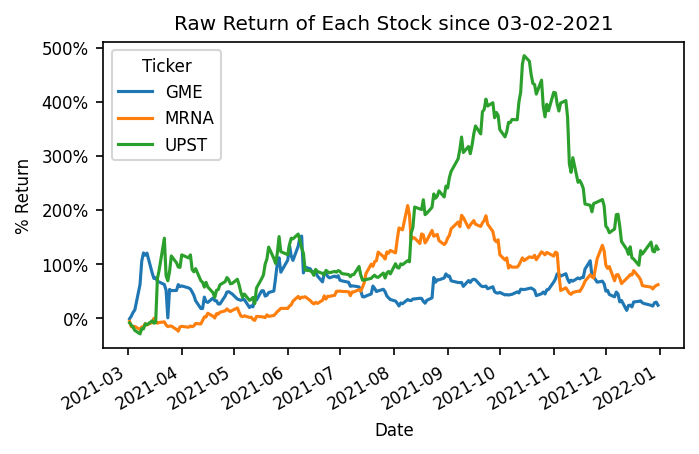

Raw Returns of Each Stock Ticker
GME    0.23
MRNA   0.61
UPST   1.27
dtype: float64


In [33]:
import matplotlib.ticker as mtick
Returns_4.add(1).cumprod().sub(1).plot(figsize=(5,3))
plt.title('Raw Return of Each Stock since 03-02-2021')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.ylabel('% Return'); plt.show()
print('Raw Returns of Each Stock ' + str(Returns_4.add(1).prod().sub(1)))

Now, comparing the return to the GME strategy ***without Margin Loan*** (2021-01-05 vs. 2021-03-02)

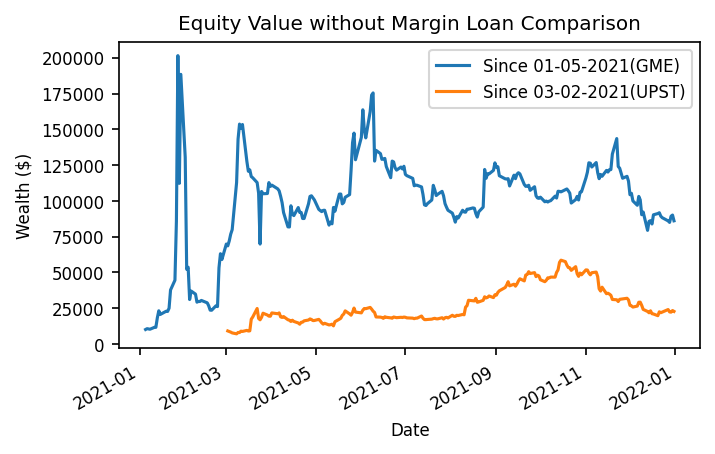

In [34]:
port_r_plot(res['x'], Returns).mul(-1).plot(figsize=(5,3))
port_r_plot(res_4['x'], Returns_4).mul(-1).plot(figsize=(5,3))
plt.title('Equity Value without Margin Loan Comparison')
plt.legend(labels = ('Since 01-05-2021(GME)','Since 03-02-2021(UPST)'))
plt.ylabel('Wealth ($)'); plt.show()

***Investing after the close of the first trading day of March with margin loan***

In [35]:
Returns_5 = Returns_4.copy()
Returns_5['Loan'] = 0

In [36]:
weights_5 = [1.25,1.25,1.25,-2.75]
res_5 = sco.minimize(
    fun = port_loan, x0 = weights_5, args = (Returns_5,),
    bounds = ((0,11),(0,11),(0,11),(-10,0)),
    constraints=({'type': 'eq', 'fun': lambda x: x.sum() - 1},
        {'type': 'ineq', 'fun': lambda x: Returns_5.add(1).cumprod().dot(x).min()}))
assert res_5['success']
res_5

     fun: -10.680410286924552
     jac: array([-1.23, -1.61, -2.27, -1.  ])
 message: 'Optimization terminated successfully'
    nfev: 40
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([  4.13,   0.  ,   6.87, -10.  ])

In [37]:
print('Total Ending Equity of the optimal portfolio since March with margin loan is ', port_loan(res_5['x'], Returns_5)*-10000)
print('Total Return of the optimal portfolio with margin loan is ', (((port_loan(res_5['x'], Returns_5)*-10000)-10000)/10000)*100, '%')

Total Ending Equity of the optimal portfolio since March with margin loan is  106804.10286924551
Total Return of the optimal portfolio with margin loan is  968.0410286924551 %


If we did not receive the newspaper until the end of the first closing day in March and were able to use the 10:1 margin loan, we would invest 41,300 in GME and 68,700 in UPST since March 2nd. Despite the fact that UPST outperformed both GME and MRNA in the period, the margin loan constraints prevent us from allocating all of the value to UPST as it has negative returns for the first few days of the investment period. To avoid a margin call, we must invest ~ 40% of the portfolio in GME, which offset some of the early losses but prevents a higher overall return by the end of the period.

The graph below shows the equity value with margin loan invested in GME and UPST since March 2nd:

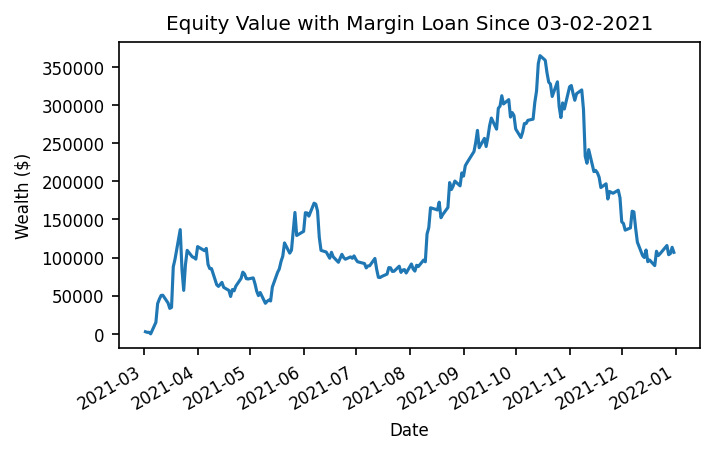

In [38]:
port_r_plot(res_5['x'], Returns_5).mul(-1).plot(figsize=(5,3))
plt.title('Equity Value with Margin Loan Since 03-02-2021')
plt.ylabel('Wealth ($)'); plt.show()

Comparing the return to the GME strategy ***with Margin Loan***(2021-01-01 vs. 2021-03-02)

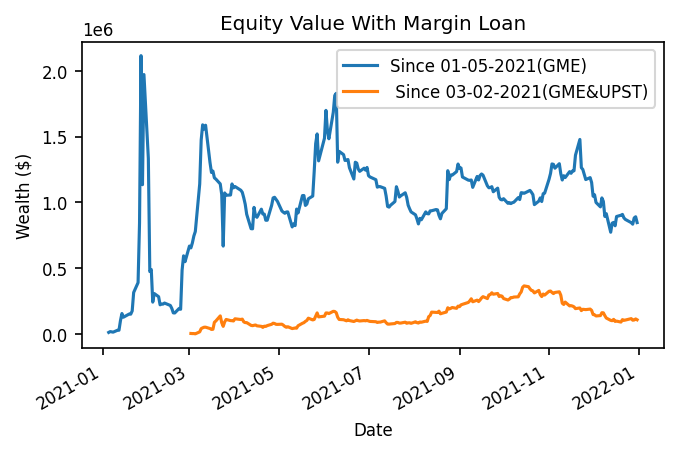

In [39]:
port_r_plot(res_1['x'], Returns_2).mul(-1).plot(figsize=(5,3))
port_r_plot(res_5['x'], Returns_5).mul(-1).plot(figsize=(5,3))
plt.title('Equity Value With Margin Loan')
plt.legend(labels = ('Since 01-05-2021(GME)',' Since 03-02-2021(GME&UPST)'))
plt.ylabel('Wealth ($)'); plt.show()

***Comparing all portfolios:***

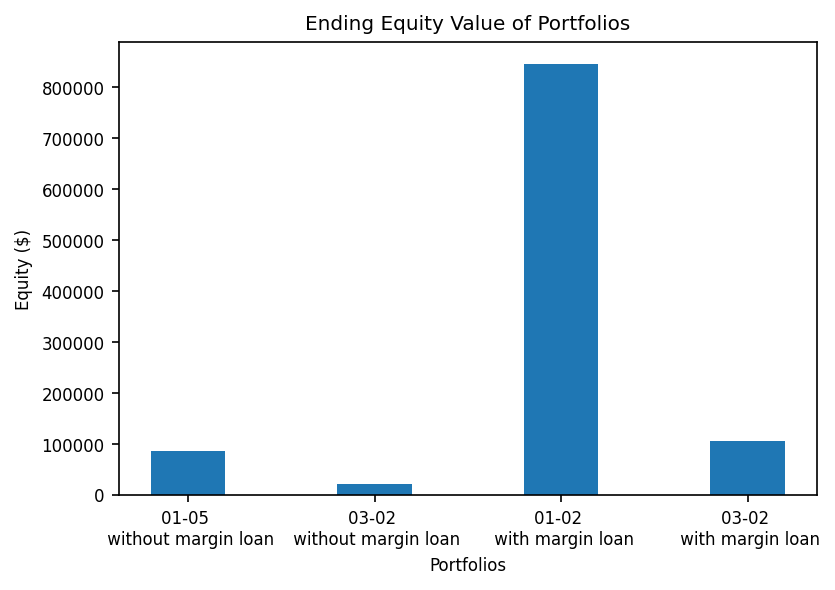

In [40]:
All_R ={'01-05 \n without margin loan':-port_r(res['x'], Returns), '03-02 \n without margin loan':-port_r(res_4['x'], Returns_4), '01-02 \n with margin loan': port_loan(res_1['x'], Returns_2)*-10000, '03-02 \n with margin loan': port_loan(res_5['x'], Returns_5)*-10000 }
Period = list(All_R.keys()); Value = list(All_R.values())
plt.bar(Period, Value, width = 0.4)
plt.xlabel('Portfolios'); plt.ylabel('Equity ($)')
plt.title('Ending Equity Value of Portfolios')
plt.rc('xtick', labelsize= 8); plt.show()